## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [179]:
import os
import sys
sys.path.append('/Users/hyadava/anaconda3/envs/car/lib/python3.4/site-packages')

import numpy as np
import cv2
import glob
import PyQt5
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    #print('img size ', img.shape)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()



test img size  (720, 1280)


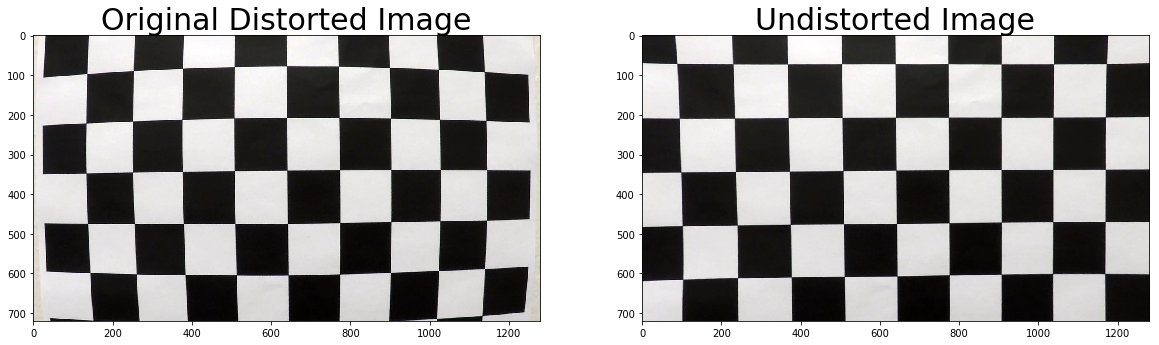

In [180]:
import pickle
%matplotlib inline

#Test on one of the calibration images
img = cv2.imread('camera_cal/calibration1.jpg')

img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_size = img.shape[0:2]
print('test img size ', img_size)

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Visualize undistortion
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

dst = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Distorted Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )



## And so on and so forth...

test img size  (720, 1280)


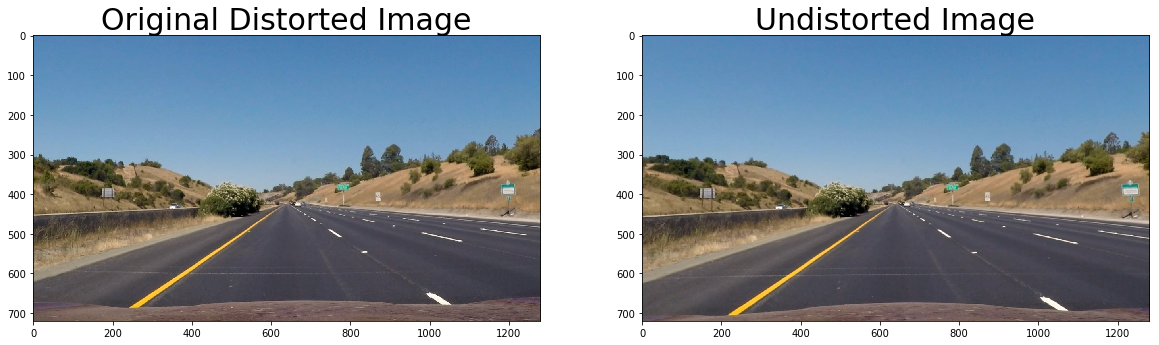

In [181]:
# Test undistortion on a raod image
img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_size = img.shape[0:2]
print('test img size ', img_size)

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Visualize undistortion
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

dst = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Distorted Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# Visualize undistortion


In [182]:
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    x = 1
    y = 0
    if(orient == 'y'):
        x = 0
        y = 1
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, x, y)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def color_threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the S channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary, s_binary

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    sobel_mag = np.sqrt(np.square(abs_sobelx) + np.square(abs_sobely))
    

    scaled_sobel = np.uint8(255*sobel_mag/np.max(sobel_mag))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    sobel_arctan = np.arctan2(abs_sobely, abs_sobelx)
    
    #scaled_sobel = np.uint8(255*sobel_arctan/np.max(sobel_arctan))
    dir_binary = np.zeros_like(sobel_arctan)
    dir_binary[(sobel_arctan >= thresh[0]) & (sobel_arctan <= thresh[1])] = 1
    return dir_binary


In [183]:
def get_thresholded_binary_img(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
       
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    color_binary, s_binary = color_threshold(img, s_thresh=(80, 100))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=sx_thresh)
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=sx_thresh)
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(60, 100))
    #dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0, np.pi/2))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0.7, 1.3))
    
    combined = np.zeros_like(gradx)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | ((s_binary == 1))] = 1

    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1)) ] = 1
    #combined[((gradx == 1) & (grady == 1))] = 1
    #combined[((gradx == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #combined[((gradx == 1)) | ((dir_binary == 1)) ] = 1
    #combined[((gradx == 1))] = 1
    return combined

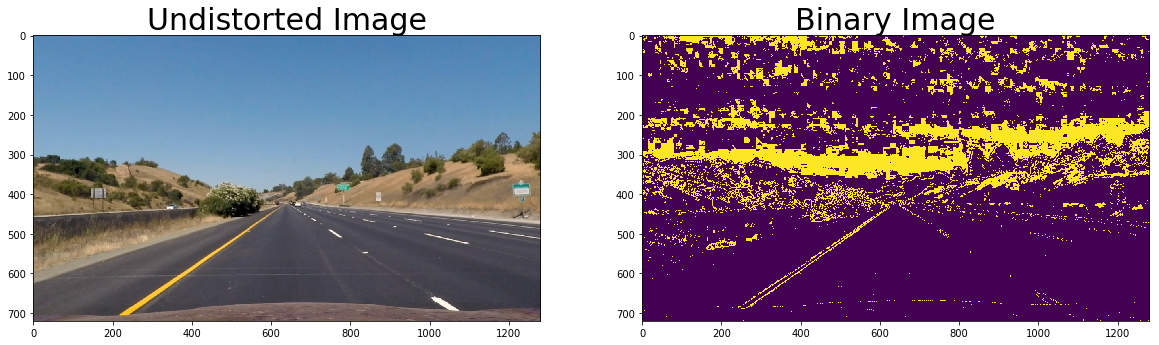

In [184]:
# Visualize undistortion and thresholded binary image
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

undistorted = cv2.undistort(img, mtx, dist, None, mtx)
binary_img = get_thresholded_binary_img(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undistorted)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(binary_img)
ax2.set_title('Binary Image', fontsize=30)

In [185]:
def add_border(im, bordersize):
    row, col= im.shape[:2]
    bottom= im[row-2:row, 0:col]
    mean= cv2.mean(bottom)[0]

    #bordersize=50
    border=cv2.copyMakeBorder(im, top=bordersize, bottom=bordersize, left=bordersize, 
                              right=bordersize, borderType= cv2.BORDER_CONSTANT, 
                              value=[255,255,255])
    return border

In [186]:
def transform_presprective(img, nx, ny, mtx, dist):

    #undist = cv2.undistort(img, mtx, dist, None, mtx)
    #gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)
    
    #src = np.float32([[210, 710], [520, 500], [800,500], [1060, 710]])
    #dst = np.float32([[210, 710], [210, 10], [1200, 10], [1060, 710]])
    
    src = np.float32([[220, 700], [520, 500], [770, 500], [1080, 700]])
    dst = np.float32([[220, 700], [220, 0], [1080,0], [1080, 700]])

    #src = np.float32([[225, 700], [520, 500], [770, 500], [1080, 700]])
    #dst = np.float32([[225, 700], [225, 0], [1080,0], [1080, 700]])

    img_size = (img.shape[1], img.shape[0])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(img, M, img_size)
    return warped, M, Minv

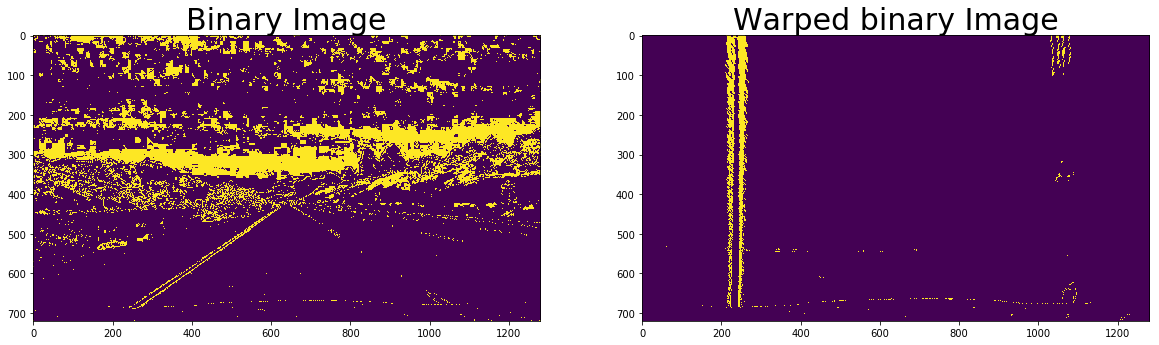

In [187]:
#Visualize the transformed image
nx = 9
ny = 6
binary_warped, M, Minv = transform_presprective(binary_img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(binary_img)
ax1.set_title('Binary Image', fontsize=30)
ax2.imshow(binary_warped)
ax2.set_title('Warped binary Image', fontsize=30)

In [188]:
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

In [189]:
def find_curvature(leftx, rightx, ploty):

    y_eval = np.max(ploty)

    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
    return left_curverad, right_curverad

In [190]:
def is_valid_lane_width(width):
    width_min = 800
    width_max = 1000
    mn = min(width)
    mx = max(width)
    is_valid =  mn > width_min and mn < width_max and mx > width_min and mn < width_max
    return is_valid


In [212]:
def find_lanes(binary_warped):
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    
    #rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    acceptable_lane_width = 850
    
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    delta = (acceptable_lane_width - (rightx_base - leftx_base))//2
    rightx_base += delta
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    lane_width = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        lane_width.append(rightx_current - leftx_current)
    
    
    mean_lane_width = np.mean(lane_width)
    

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    left_rad, right_rad = find_curvature(left_fitx, right_fitx, ploty)


    
    return out_img, left_fit, right_fit, ploty, lane_width, left_rad, right_rad
    

(720, 0)

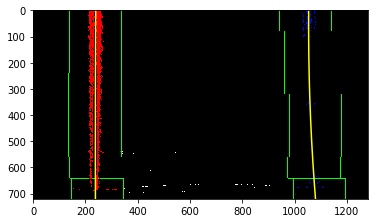

In [213]:
# visualize the lane fiting 

out_img, left_fit, right_fit, ploty, lane_width, left_rad, right_rad = find_lanes(binary_warped)

left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

#left_rad, right_rad = find_curvature(left_fit, right_fit, ploty)
#print('left radius ', left_rad, ' right radius ', right_rad)

In [214]:
def mark_known_lanes(binary_warped, left_fit, right_fit):
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    lane_pts = np.subtract(np.int_([right_line_pts]), np.int_([left_line_pts]))
   
    n = lane_pts.shape[2]
    width = lane_pts.reshape(n,2)[:,0].tolist()
    left_rad, right_rad = find_curvature(left_fitx, right_fitx, ploty)
    l_pos = np.mean(np.int_([right_line_pts]))
    r_pos = np.mean(np.int_([right_line_pts]))
    
    img_center = binary_warped.shape[1]/2                      
    car_pos = (l_pos + r_pos)/2 - img_center 

    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    car_pos = car_pos * xm_per_pix
                           
    return result, left_fit, right_fit, ploty, left_fitx, right_fitx, left_rad, right_rad, width, car_pos

lane_width  814   838  car_pos  0.369867857143


(720, 0)

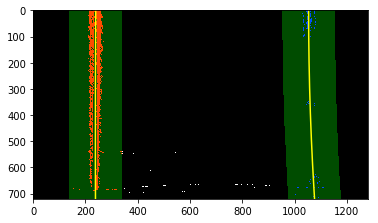

In [215]:
#visualize marked lanes
result, left_fit, right_fit, ploty, left_fitx, right_fitx, left_rad, right_rad, lane_width, car_pos = mark_known_lanes(binary_warped, left_fit, right_fit)

print('lane_width ', min(lane_width), ' ', max(lane_width), ' car_pos ', car_pos)

plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [216]:
left_rad, right_rad = find_curvature(left_fitx, right_fitx, ploty)
print('left radius ', left_rad, ' right radius ', right_rad)

left radius  31536.7219591  right radius  3728.80627567


In [217]:
def project_to_road(warped, left_fitx, right_fitx, Minv, image, undist):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

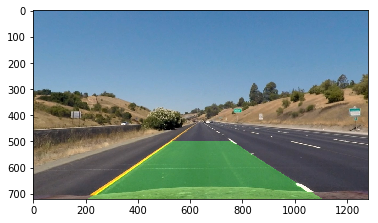

In [218]:
road_img = project_to_road(binary_warped, left_fitx, right_fitx, Minv, img, undistorted)
plt.imshow(road_img)

In [224]:
def are_lines_parallel(left_radius, right_radius):
    is_parallel = False
    if(left_radius > right_radius and left_radius/right_radius < 2):
        is_parallel = True
    elif(right_radius > left_radius and right_radius/left_radius < 2):
        is_parallel = True
    return is_parallel

def is_curvature_correct(left_radius, right_radius, prev_left, prev_right):
    is_parallel = False
    if(left_radius > right_radius and left_radius/right_radius < 3):
        is_parallel = True
    elif(right_radius > left_radius and right_radius/left_radius < 3):
        is_parallel = True
    
    if(prev_left == None or prev_right == None):
        return is_parallel

    is_left_similar = False
    if(left_radius > prev_left and left_radius/prev_left < 3):
        is_left_similar = True
    elif(left_radius < prev_left and prev_left/left_radius < 3):
        is_left_similar = True

    is_right_similar = False
    if(right_radius > prev_right and right_radius/prev_right < 3):
        is_right_similar = True
    elif(right_radius < prev_right and prev_right/right_radius < 3):
        is_right_similar = True
        
    if(is_parallel and is_left_similar and is_right_similar):
        return True
    else:
        return False


#Function to run the lane finding pipeline
prev_left_fit = None
prev_right_fit = None
prev_left_fitx = None
prev_right_fitx = None
prev_left_rad = None
prev_right_rad = None

lane_width = 0
bootstrap = 0

def lane_finding_pipeline(img, show_intermediate_imgs=False, print_curvature=False, blind_search=False):
    
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    binary_img = get_thresholded_binary_img(img)
    binary_warped, M, Minv = transform_presprective(binary_img, nx, ny, mtx, dist)

    global prev_left_fit
    global prev_right_fit
    global prev_left_fitx
    global prev_right_fitx
    global lane_width
    global prev_left_rad
    global prev_right_rad
    global bootstrap
    
    if(bootstrap < 5):
        blind_search = True
        bootstrap += 1
        
    out_img, left_fit, right_fit, ploty, width, left_rad, right_rad = find_lanes(binary_warped)
    if(lane_width == 0 or (is_valid_lane_width(width) and are_lines_parallel(left_rad, right_rad))  or blind_search):
        prev_left_fit = left_fit
        prev_right_fit = right_fit
        lane_width = width

    result, left_fit, right_fit, ploty,left_fitx, right_fitx, left_rad, right_rad, width, car_pos = mark_known_lanes(binary_warped, prev_left_fit, prev_right_fit)

    if(prev_left_fitx == None or (are_lines_parallel(left_rad, right_rad) and is_valid_lane_width(width))) :
        prev_left_fit = left_fit
        prev_right_fit = right_fit
        lane_width = width
        prev_left_fitx = left_fitx
        prev_right_fitx = right_fitx

    prev_left_rad = left_rad
    prev_right_rad = right_rad


    road_img = project_to_road(binary_warped, prev_left_fitx, prev_right_fitx, Minv, img, undistorted)
    pos_label = 'right'
    if(car_pos < 0):
        pos_label = 'left'

    font = cv2.FONT_HERSHEY_SIMPLEX    
    txt = 'Curvature: '+str(max(left_rad,right_rad))+' position: '+ str(car_pos) + ' mt ' + pos_label + ' of center'
    cv2.putText(road_img, txt,(10,100), font, 1,(255,255,255),2)
    
    if(show_intermediate_imgs):
        f, ax = plt.subplots(6, 1, figsize=(20,40))
        ax[0].imshow(undistorted)
        ax[0].set_title("undistorted")
        ax[1].imshow(binary_img)
        ax[1].set_title("binary")
        ax[2].imshow(binary_warped)
        ax[2].set_title("binary_warped")
        ax[3].imshow(out_img)
        ax[3].set_title("lane finding")
        ax[4].imshow(result)
        ax[4].set_title("marked lanes")
        ax[5].imshow(road_img)
        ax[5].set_title("final")
    if(print_curvature):
        #print('left_fit ', left_fit, ' right_fit ', right_fit)
        #left_rad, right_rad = find_curvature(left_fitx, right_fitx, ploty)
        print('parallel ', are_lines_parallel(left_rad, right_rad))
        print('left radius ', left_rad, ' right radius ', right_rad, ' ratio ', left_rad/right_rad, 
              ' width', min(lane_width), ' ', max(lane_width))
        print(txt)

    return road_img


parallel  False
left radius  2398.38797894  right radius  6770.70405692  ratio  0.354230218716  width 873   930
Curvature: 6770.70405692 position: 0.50086547619 mt right of center


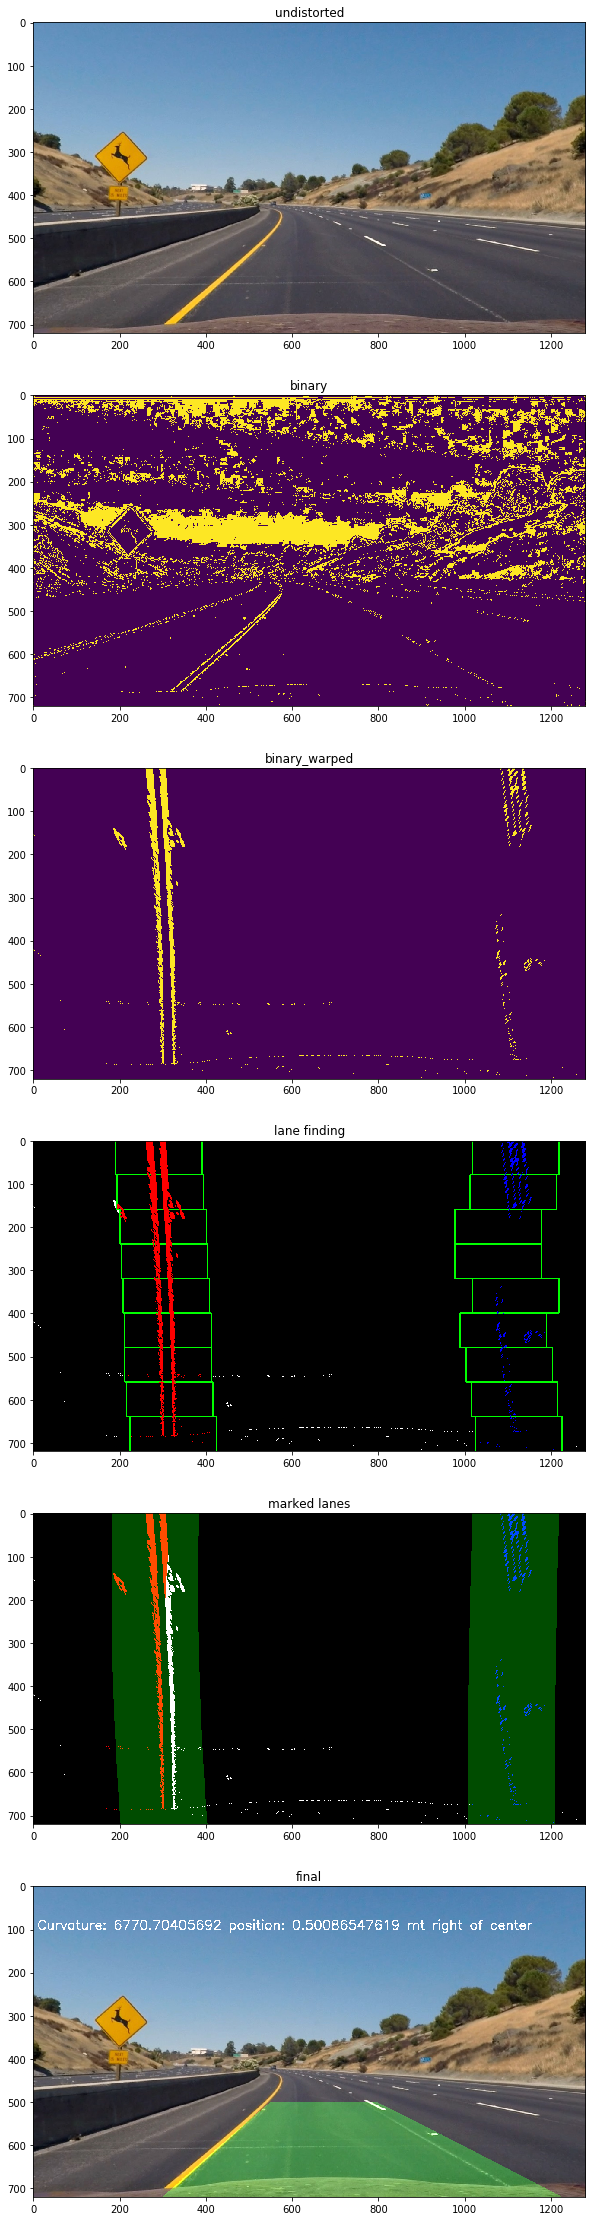

In [233]:
img = cv2.imread('test_images/test2.jpg')
img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#road_img = lane_finding_pipeline(img, show_intermediate_imgs=True, print_curvature=True, blind_search=True)
road_img = lane_finding_pipeline(img_rgb, show_intermediate_imgs=True, print_curvature=True)


found  8  test images
parallel  False
left radius  31536.7219591  right radius  3728.80627567  ratio  8.45759195504  width 801   842
Curvature: 31536.7219591 position: 0.369867857143 mt right of center
parallel  True
left radius  11464.4739275  right radius  9377.65616416  ratio  1.22253084638  width 824   845
Curvature: 11464.4739275 position: 0.40307609127 mt right of center
parallel  True
left radius  395.67551078  right radius  237.608354259  ratio  1.66524241967  width 674   774
Curvature: 395.67551078 position: 0.465128174603 mt right of center
parallel  False
left radius  5039.79506825  right radius  16842.3641168  ratio  0.299233233132  width 772   829
Curvature: 16842.3641168 position: 0.499599107143 mt right of center
parallel  False
left radius  4452.02007633  right radius  1145.90141317  ratio  3.88516850155  width 814   849
Curvature: 4452.02007633 position: 0.521729365079 mt right of center
parallel  True
left radius  557.698345719  right radius  281.026173433  ratio  1.9

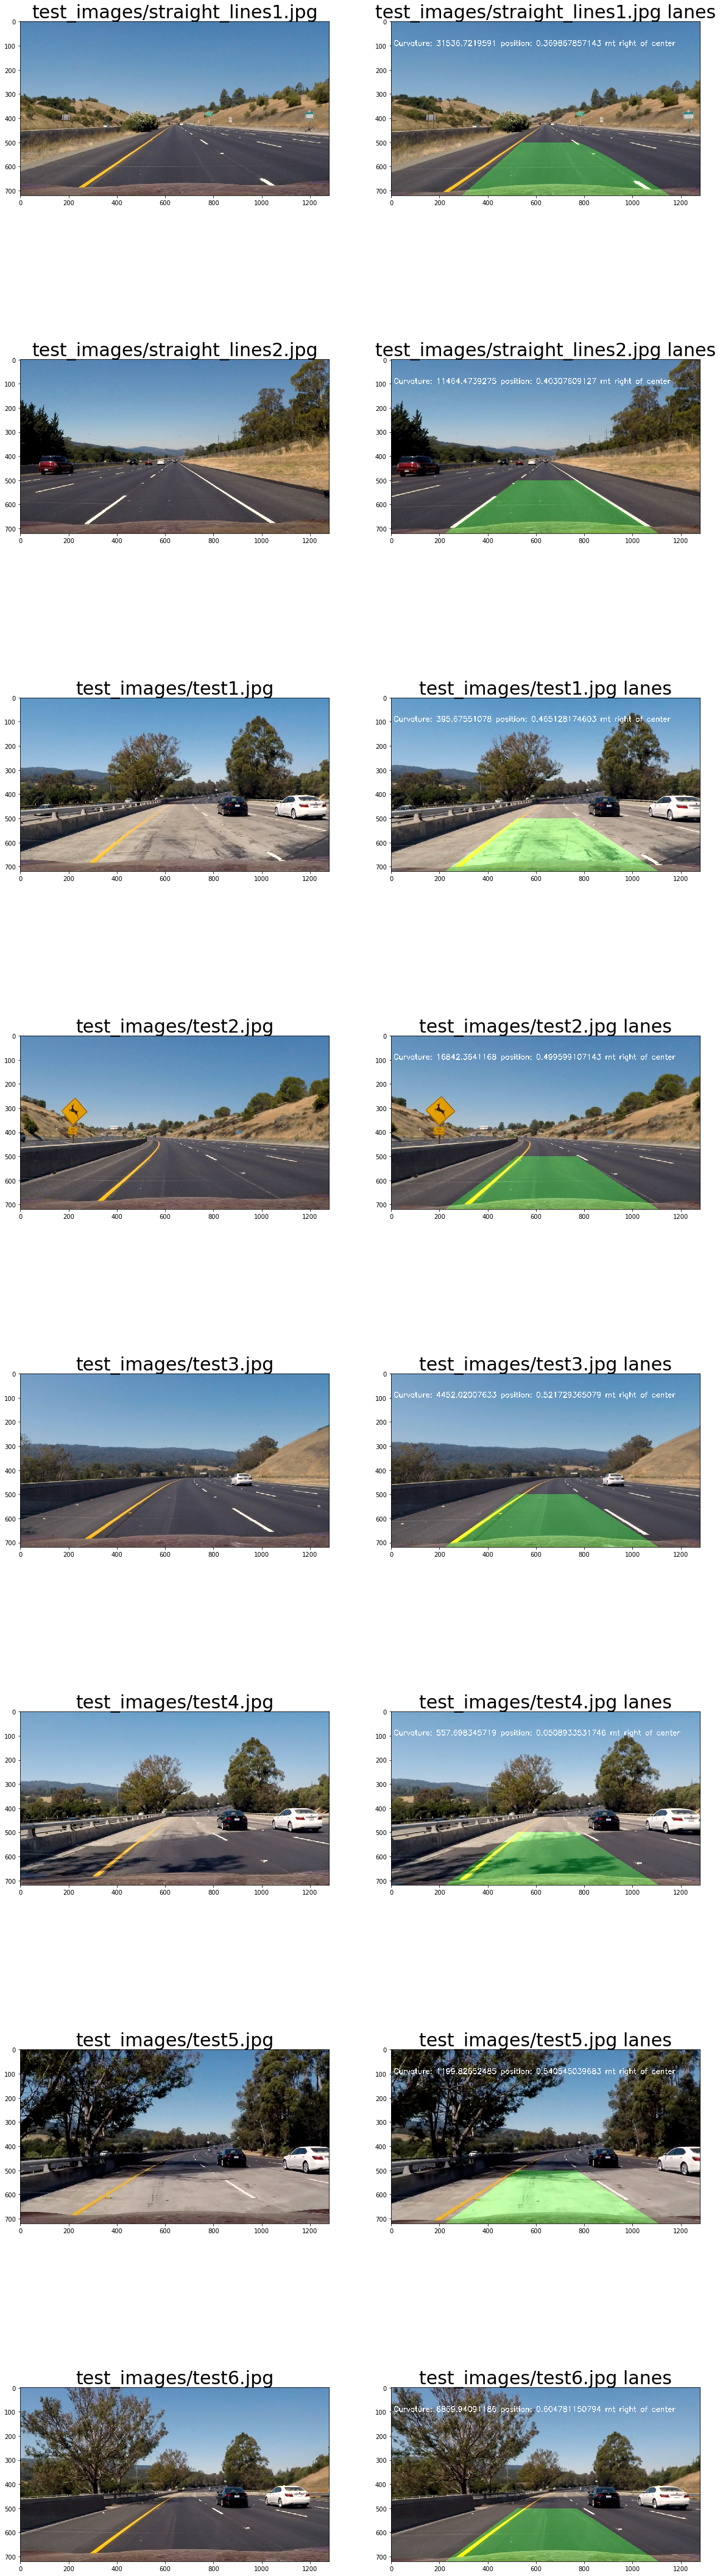

In [226]:
#Run the pipeline for all test images

test_images = glob.glob('test_images/*.jpg')

print('found ', len(test_images), ' test images')

f, ax = plt.subplots(len(test_images), 2, figsize=(20,80))
#f, ax = plt.subplots(len(test_images), 2)

# Step through the list and apply the lane marking pipeline
i = 0
for fname in test_images:
    
    img_bgr = cv2.imread(fname)
    img = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)
    #img = img_bgr
    #road_img = lane_finding_pipeline(img, print_curvature=True, blind_search=True)
    road_img = lane_finding_pipeline(img, print_curvature=True, blind_search=True)

    ax[i, 0].imshow(img)
    ax[i, 0].set_title(fname, fontsize=30)
    
    ax[i, 1].imshow(road_img)
    ax[i, 1].set_title(fname+' lanes', fontsize=30)
    
    i += 1


In [230]:
# Apply the pipeline to the project video
from moviepy.editor import VideoFileClip
from IPython.display import HTML

project_vid_output = 'proj4_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_vid_clip = clip1.fl_image(lane_finding_pipeline)

%time project_vid_clip.write_videofile(project_vid_output, audio=False)

[MoviePy] >>>> Building video proj4_video.mp4
[MoviePy] Writing video proj4_video.mp4


100%|█████████▉| 1260/1261 [06:44<00:00,  3.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: proj4_video.mp4 

CPU times: user 18min, sys: 2min 30s, total: 20min 31s
Wall time: 6min 45s


In [231]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_vid_output))